Nutrient comparisons with edited dataset using surface instead of 2m for depth. Limited between 01feb15 and 02may15

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import os
%matplotlib inline

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')

In [5]:
nutrients_2015
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [6]:
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])

In [7]:
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]

In [8]:
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(890)])
dates = np.ma.masked_outside(dates, datetime.datetime(2015,1,31), datetime.datetime(2015,5,2))
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates.mask)

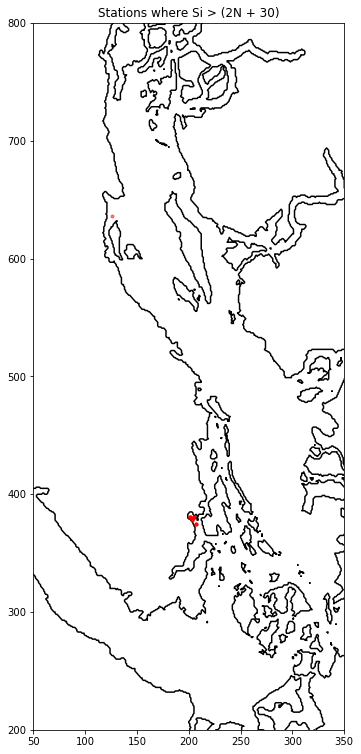

In [9]:
fig, ax = plt.subplots(figsize = (13,13))
for n in range(890):
    if Yinds.mask[n] == False:
        if cs_si[n] > (2*cs_no23[n]+30):
            ax.plot(Xinds[n], Yinds[n], 'r.', alpha = 0.5)
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(200, 800)
ax.set_xlim(50, 350)
ax.set_title('Stations where Si > (2N + 30)');

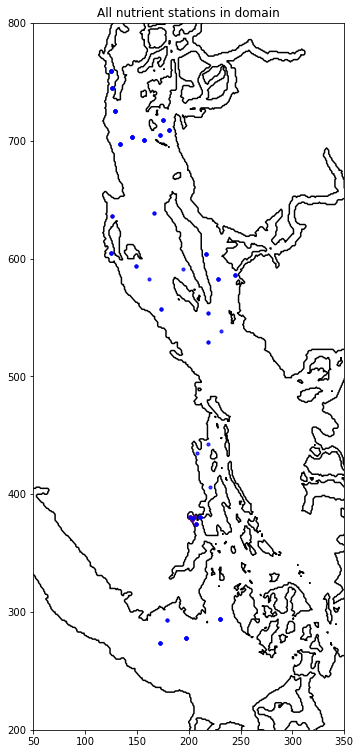

In [10]:
fig, ax = plt.subplots(figsize = (13,13))
for n in range(890):
    if Yinds.mask[n] == False:
        if cs_si[n] > (2*cs_no23[n]+30):
            ax.plot(Xinds[n], Yinds[n], 'r.', alpha = 0.5)
        else:
            ax.plot(Xinds[n], Yinds[n], 'b.', alpha = 0.5)
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(200, 800)
ax.set_xlim(50, 350)
ax.set_title('All nutrient stations in domain');

In [11]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [13]:
list_of_model_si = np.ma.masked_array(np.zeros((890)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((890)), mask = True)
for n in range(890):
    if dates.mask[n] == False:
        Yind = int(Yinds[n])
        Xind = int(Xinds[n])
        date = dates[n]
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if ((depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            si_val = nuts.variables['silicon'][0, 18, Yind, Xind]
            ni_val = nuts.variables['nitrate'][0, 18, Yind, Xind]
            list_of_model_si.mask[n] = False
            list_of_model_si[n] = si_val
            list_of_model_ni.mask[n] = False
            list_of_model_ni[n] = ni_val
        elif ((depths[n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            si_val = nuts.variables['silicon'][0, 0, Yind, Xind]
            ni_val = nuts.variables['nitrate'][0, 0, Yind, Xind]
            list_of_model_si.mask[n] = False
            list_of_model_si[n] = si_val
            list_of_model_ni.mask[n] = False
            list_of_model_ni[n] = ni_val

In [14]:
cs_ni = np.ma.masked_array(cs_no23, mask = list_of_model_ni.mask)
cs_si = np.ma.masked_array(cs_si, mask = list_of_model_si.mask)
stations = np.ma.masked_array(stations, mask = list_of_model_si.mask)

In [15]:
depths = np.ma.masked_array(depths, mask = list_of_model_ni.mask)

In [16]:
np.ma.count(cs_ni)

267

In [17]:
stations.shape

(890,)

In [18]:
cb_model_si = np.array([])
cb_model_ni = np.array([])
cb_cs_si = np.array([])
cb_cs_ni = np.array([])
cb_depths = np.array([])
for n in range(890):
    if stations.mask[n] == False:
        if stations[n][:2] == 'CB':
            cb_model_si = np.append(cb_model_si, list_of_model_si[n])
            cb_model_ni = np.append(cb_model_ni, list_of_model_ni[n])
            cb_cs_si = np.append(cb_cs_si, cs_si[n])
            cb_cs_ni = np.append(cb_cs_ni, cs_ni[n])
            cb_depths = np.append(cb_depths, depths[n])
            list_of_model_ni.mask[n] = True
            list_of_model_si.mask[n] = True
            cs_ni.mask[n] = True
            cs_si.mask[n] = True

In [19]:
Yinds = np.ma.masked_array(Yinds, mask = list_of_model_ni.mask)
Xinds = np.ma.masked_array(Xinds, mask = list_of_model_ni.mask)

In [20]:
np.ma.count(list_of_model_ni)

227

bias =  3.39307301786
RMSE = 7.58078239528
Willmott = 0.771486770448


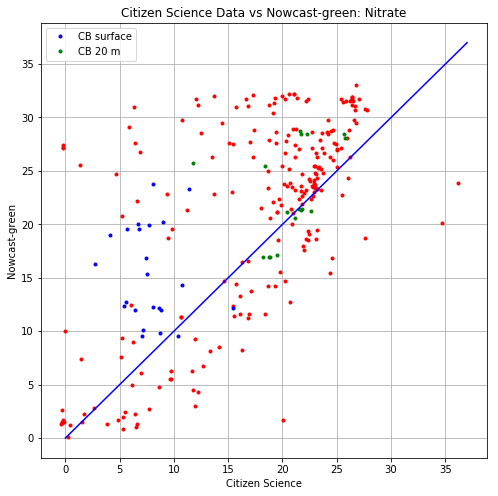

In [21]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_ni, list_of_model_ni, 'r.')
ax.plot(cb_cs_ni[cb_depths == 2], cb_model_ni[cb_depths == 2], 'b.', label = 'CB surface')
ax.plot(cb_cs_ni[cb_depths == 20], cb_model_ni[cb_depths == 20], 'g.',label = 'CB 20 m' )
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
plt.legend()
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_ni)**2) /
                              266)))
xbar = np.mean(cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_ni - xbar))**2))))

bias =  1.2372232243
RMSE = 10.8485887668
Willmott = 0.832103189038


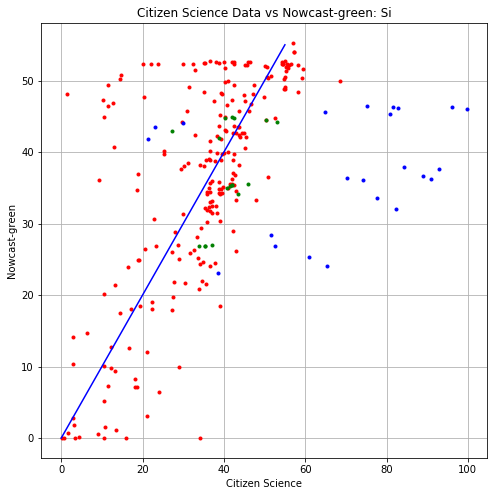

In [22]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.plot(cb_cs_si[cb_depths == 2], cb_model_si[cb_depths == 2], 'b.', label = 'CB surface')
ax.plot(cb_cs_si[cb_depths == 20], cb_model_si[cb_depths == 20], 'g.',label = 'CB 20 m' )
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              266)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

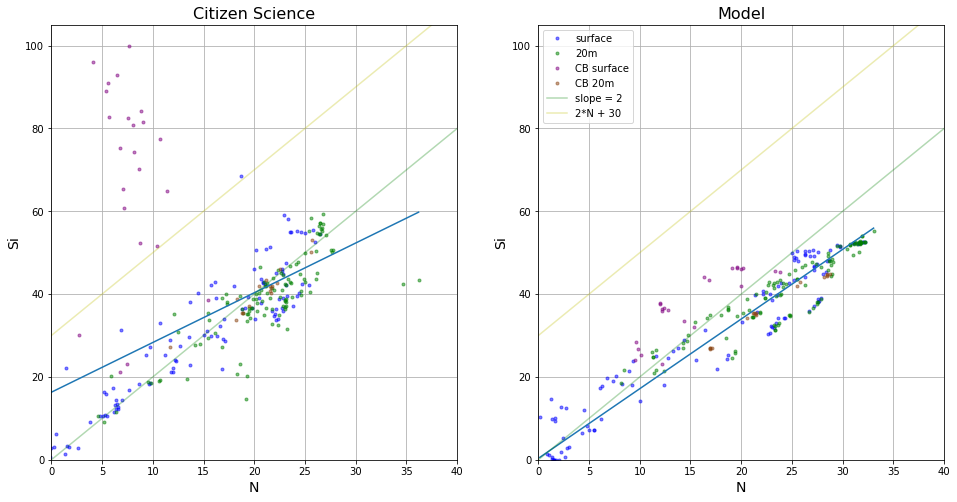

In [25]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_ni[depths == 2], cs_si[depths == 2], 
           'b.', alpha = 0.5)
ax[0].plot(cs_ni[depths == 20], cs_si[depths == 20], 
           'g.', alpha = 0.5)
ax[0].plot(cb_cs_ni[cb_depths == 20], cb_cs_si[cb_depths == 20], 
           '.', alpha = 0.5, color = 'saddlebrown')
ax[0].plot(cb_cs_ni[cb_depths == 2], cb_cs_si[cb_depths == 2], 
           '.', alpha = 0.5, color = 'purple')
ax[0].plot(np.unique(cs_ni), np.poly1d(np.polyfit(cs_ni, cs_si, 1))(np.unique(cs_ni)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 2], 
           list_of_model_si[nutrients_2015['depth'].values == 2], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 20], 
           list_of_model_si[nutrients_2015['depth'].values == 20], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(cb_model_ni[cb_depths == 2], cb_model_si[cb_depths == 2], 
           '.', alpha = 0.5, color = 'purple', label = 'CB surface')
ax[1].plot(cb_model_ni[cb_depths == 20], cb_model_si[cb_depths == 20], 
           '.', alpha = 0.5, color = 'saddlebrown', label = 'CB 20m')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [26]:
m1, b1 = np.polyfit(cs_ni, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.20089704365
CitSci y int = 16.3134925754
model slope = 1.68226513151
model y int = 0.343914729435


In [28]:
datetime.date(2015,8,28) + datetime.timedelta(days=10)

datetime.date(2015, 9, 7)